<font color='brown' size='15' style='line-height: 1.01;'><b>Overview</b></font>


This script tackles the task of predicting house prices, as outlined in the Kaggle competition "House Prices - Advanced Regression Techniques." The challenge involves using 79 explanatory variables to predict the sales prices of houses in Ames, Iowa, emphasizing feature engineering and advanced regression techniques. For more details and the dataset, visit the competition page: [House Prices Competition](https://kaggle.com/competitions/house-prices-advanced-regression-techniques).

In [21]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

test_data = pd.read_csv("/Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/test.csv")
train_data = pd.read_csv("/Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/train.csv")

In [22]:
train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [23]:
test_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

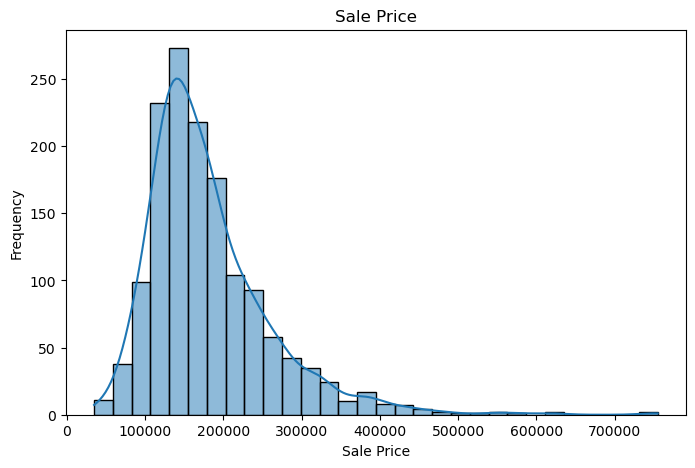

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting the distribution of predicted SalePrice
plt.figure(figsize=(8, 5), dpi=100)
sns.histplot(train_data['SalePrice'], kde=True, bins=30)
plt.title('Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

In [26]:

# Calculate the total number of missing values
total_missing_values = train_data.isnull().sum().sum()

# Calculate the number of rows that have at least one null value
rows_with_null = train_data.isnull().any(axis=1).sum()

print(f"Total missing values in the DataFrame: {total_missing_values}")
print(f"Number of rows with at least one null value: {rows_with_null}")


Total missing values in the DataFrame: 6965
Number of rows with at least one null value: 1460


In [27]:
# Preprocess Training Data
# Fill in missing values for numerical features
train_data.fillna(train_data.mean(), inplace=True)

# Convert infinite values to NaN and then fill or drop them
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data.fillna(train_data.mean(), inplace=True)  # or another appropriate method

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data)

# Separate the features and the target variable
X_train = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']

/var/folders/z3/bkgw4vw17fx7qmlcf7_4tdd00000gn/T/ipykernel_3339/2210555504.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.fillna(train_data.mean(), inplace=True)
/var/folders/z3/bkgw4vw17fx7qmlcf7_4tdd00000gn/T/ipykernel_3339/2210555504.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.fillna(train_data.mean(), inplace=True)  # or another appropriate method


<font color='brown' size='11' style='line-height: 1.01;'><b>XGBoost Parameter Tuning</b></font>

In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np


# Define a range of hyperparameters for the grid search
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5,9],
    'gamma': [0, 0.1],
    'subsample': [0.5,0.7],
    'colsample_bytree': [0.5, 0.7],
}

# Initialize the model
xgb_model = XGBRegressor()

# Setup grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    cv=5,
    verbose=0
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best score, converting MSE to RMSE for a more interpretable result
print("Best score:", np.sqrt(-grid_search.best_score_))

best_model = grid_search.best_estimator_


/Users/dadmehr/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
Best score: 26228.926539207052


In [ ]:
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Best score: 25577.6397810356

In [ ]:
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 2, 'n_estimators': 1300, 'subsample': 0.6}
Best score: 25464.451308619082

In [ ]:
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.5}
Best score: 26516.66967452978

<font color='DarkMagenta' size='11' style='line-height: 1.01;'><b>XGBRegressor</b></font>

<font color='DarkMagenta' size='6' style='line-height: 1.01;'>a great choice! :)</font>

In [28]:
from xgboost import XGBRegressor
import pandas as pd

# Assuming train_data and test_data have been preprocessed up to the point of OLS model fitting

# Preparing X_train and y_train for XGBoost, assuming 'SalePrice' is the target variable
X_train = train_data.drop(['SalePrice'], axis=1)
y_train = train_data['SalePrice']

# Initialize the XGBoost model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, gamma=0, subsample=0.8, 
    colsample_bytree=0.8, max_depth=20)

# Fit the XGBoost model
# Ensure 'Id' and potentially 'const' columns are not included in the model fitting
X_train_xgb = X_train.drop(columns=['Id', 'const'], errors='ignore')
xgb_model.fit(X_train_xgb, y_train)

# Prepare the test data for XGBoost prediction
# Make sure to drop 'Id' and 'const' columns if they were included during OLS preprocessing
test_features_xgb = test_data.drop(columns=['Id', 'const'], errors='ignore').reindex(columns=X_train_xgb.columns)

# Predict the SalePrice for the test data with the XGBoost model
xgb_predictions = xgb_model.predict(test_features_xgb)

# Prepare the submission DataFrame for XGBoost predictions
xgb_submission = pd.DataFrame({
    "Id": test_data['Id'],
    "SalePrice": xgb_predictions
})

# Specify the file path for saving the XGBoost predictions
xgb_file_path = '/Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/xgb_predictions.csv'

# Save the XGBoost predictions to a CSV file
xgb_submission.to_csv(xgb_file_path, index=False)

print(f'XGBoost submission file has been saved to {xgb_file_path}')


XGBoost submission file has been saved to /Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/xgb_predictions.csv


In [29]:
xgb_submission

,Id,SalePrice
0,1461,134344.906250
1,1462,165286.406250
2,1463,184950.906250
3,1464,186043.187500
4,1465,201301.281250
...,...,...
1454,2915,105533.578125
1455,2916,99439.960938
1456,2917,173591.031250
1457,2918,127724.898438


<font color='brown' size='10' style='line-height: 1.01;'><b>Ordinary Least Squares</b></font>

<font color='brown' size='5' style='line-height: 1.01;'>worst choice! :)</font>

In [30]:
# Preprocess Training Data
# Fill in missing values for numerical features
train_data.fillna(train_data.mean(), inplace=True)

# Convert infinite values to NaN and then fill or drop them
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data.fillna(train_data.mean(), inplace=True)  # or another appropriate method

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data)

# Separate the features and the target variable
X_train = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']

# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)

# Fit the OLS model
model = sm.OLS(y_train, X_train).fit()

# Preprocess Test Data
# Fill in missing values for numerical features
test_data.fillna(test_data.mean(), inplace=True)

# Convert infinite values to NaN and then fill or drop them
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.fillna(test_data.mean(), inplace=True)  # or another appropriate method

# Ensure test_data has the same columns as X_train, add missing columns with default value 0
test_data = pd.get_dummies(test_data)
test_data = test_data.reindex(columns = X_train.columns, fill_value=0)

# Predict the SalePrice for the test data
predictions = model.predict(test_data)


# Prepare the submission DataFrame
submission = pd.DataFrame({
    "Id": test_data['Id'],
    "SalePrice": predictions
})

# Specify your desired file path
file_path = '/Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/ols_predictions.csv'

# Save the DataFrame to a CSV file
submission.to_csv(file_path, index=False)

print(f'Submission file has been saved to {file_path}')

Submission file has been saved to /Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/ols_predictions.csv


/var/folders/z3/bkgw4vw17fx7qmlcf7_4tdd00000gn/T/ipykernel_3339/567072253.py:24: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data.fillna(test_data.mean(), inplace=True)
/var/folders/z3/bkgw4vw17fx7qmlcf7_4tdd00000gn/T/ipykernel_3339/567072253.py:28: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data.fillna(test_data.mean(), inplace=True)  # or another appropriate method


In [31]:
submission

,Id,SalePrice
0,1461,84777.051969
1,1462,133077.512010
2,1463,159028.327963
3,1464,169367.280179
4,1465,177608.441099
...,...,...
1454,2915,58177.352307
1455,2916,53677.427528
1456,2917,153147.487421
1457,2918,89103.162955


In [ ]:
# Print the summary of the model
#print(model.summary())

<font color='brown' size='6' style='line-height: 1.01;'><b>Performance on Kaggle</b></font>

This basic OLS (Ordinary Least Squares) prediction model achieved a score of 0.729 in the Kaggle competition's submission segment.

<font color='brown' size='10' style='line-height: 1.01;'><b>Random Forest Regressor</b></font>

In [33]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Note: Preprocessing steps for train_data and test_data must have been completed here.

# Assuming train_data and test_data have been preprocessed up to the point of OLS model fitting

# Preparing X_train and y_train for Random Forest, assuming 'SalePrice' is the target variable
X_train = train_data.drop(['SalePrice'], axis=1)
y_train = train_data['SalePrice']

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fit the Random Forest model
# Ensure 'Id' and potentially 'const' columns are not included in the model fitting
X_train_rf = X_train.drop(columns=['Id', 'const'], errors='ignore')
rf_model.fit(X_train_rf, y_train)

# Prepare the test data for Random Forest prediction
# Make sure to drop 'Id' and 'const' columns if they were included during OLS preprocessing
test_features_rf = test_data.drop(columns=['Id', 'const'], errors='ignore').reindex(columns=X_train_rf.columns)

# Predict the SalePrice for the test data with the Random Forest model
rf_predictions = rf_model.predict(test_features_rf)


# Prepare the submission DataFrame for Random Forest predictions
rf_submission = pd.DataFrame({
    "Id": test_data['Id'],
    "SalePrice": rf_predictions
})

# Specify the file path for saving the Random Forest predictions
rf_file_path = '/Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/rf_predictions.csv'

# Save the Random Forest predictions to a CSV file
rf_submission.to_csv(rf_file_path, index=False)

print(f'Random Forest submission file has been saved to {rf_file_path}')


Random Forest submission file has been saved to /Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/rf_predictions.csv


In [34]:
rf_submission

,Id,SalePrice
0,1461,128340.040
1,1462,155689.916
2,1463,179988.077
3,1464,182529.162
4,1465,197785.208
...,...,...
1454,2915,86310.008
1455,2916,87352.683
1456,2917,150748.765
1457,2918,113932.182


<font color='brown' size='6' style='line-height: 1.01;'><b>Model Performance on Kaggle</b></font>

The Random Forest model scored an RMSE of 0.148 in the Kaggle submission, significantly outperforming the OLS model. This lower score reflects a higher accuracy in price predictions.

Top 20 Feature Importances:
OverallQual     0.578499
GrLivArea       0.109042
TotalBsmtSF     0.039213
2ndFlrSF        0.035987
BsmtFinSF1      0.028051
GarageCars      0.022666
1stFlrSF        0.022526
GarageArea      0.014373
LotArea         0.012670
YearBuilt       0.009109
YearRemodAdd    0.006535
FullBath        0.006497
LotFrontage     0.006406
TotRmsAbvGrd    0.006260
BsmtUnfSF       0.005167
MasVnrArea      0.004800
OpenPorchSF     0.004634
WoodDeckSF      0.004569
OverallCond     0.004440
GarageYrBlt     0.004433
dtype: float64


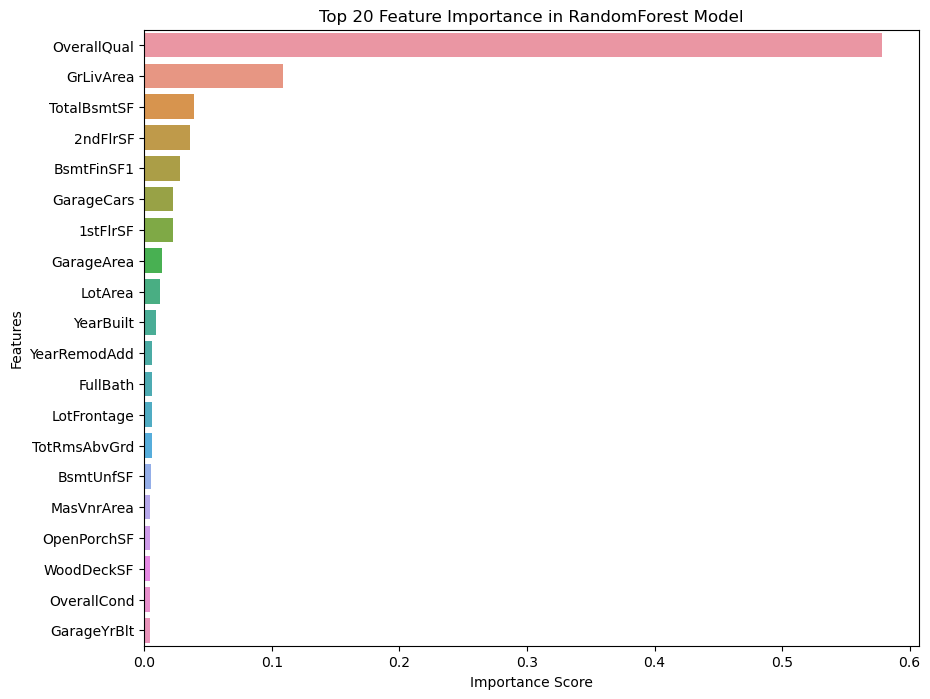

In [37]:
# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Create a pandas Series to associate feature names with their importance scores
importances = pd.Series(feature_importances, index=X_train_rf.columns)

# Sort the importances in descending order and select the top 20
sorted_importances = importances.sort_values(ascending=False)[:20]

print("Top 20 Feature Importances:")
print(sorted_importances)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title('Top 20 Feature Importance in RandomForest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


<font color='brown' size='6' style='line-height: 1.01;'><b>Model Performance on Kaggle</b></font>

The XGBoost prediction model registered a modest score of 0.13415 in the Kaggle competition.

<font color='brown' size='10' style='line-height: 1.01;'><b>Lasso</b></font>

In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Assuming train_data and test_data are already loaded

# Preprocess Training Data
# Fill in missing values for numerical features
train_data.fillna(train_data.mean(), inplace=True)

# Convert infinite values to NaN and then fill or drop them
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data.fillna(train_data.mean(), inplace=True)  # or another appropriate method

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data)

# Separate the features and the target variable
X_train = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']

# It's often a good idea to scale your data for Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit the Lasso model
lasso_model = Lasso(alpha=1)  # You can adjust the alpha parameter
lasso_model.fit(X_train_scaled, y_train)

# Preprocess Test Data in the same way as Training Data
test_data.fillna(test_data.mean(), inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.fillna(test_data.mean(), inplace=True)
test_data = pd.get_dummies(test_data)
test_data = test_data.reindex(columns = X_train.columns, fill_value=0)

# Don't forget to scale the test data as well
X_test_scaled = scaler.transform(test_data.drop('SalePrice', axis=1, errors='ignore'))  # Ensure 'SalePrice' is not in test data

# Predict the SalePrice for the test data
predictions = lasso_model.predict(X_test_scaled)

# Prepare the submission DataFrame
submission = pd.DataFrame({
    "Id": test_data['Id'],
    "SalePrice": predictions
})

# Specify your desired file path
file_path = '/Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/lasso_predictions.csv'

# Save the DataFrame to a CSV file
submission.to_csv(file_path, index=False)

print(f'Submission file has been saved to {file_path}')


Submission file has been saved to /Users/dadmehr/Codes/Python/house-prices-advanced-regression-techniques/lasso_predictions.csv


/Users/dadmehr/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+11, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


In [ ]:
submission

<font color='brown' size='6' style='line-height: 1.01;'><b>Model Performance on Kaggle</b></font>

The Lasso prediction model registered a modest score of 0.189.